<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Module%205/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

# Model Evaluation and Refinement

Estimated time needed: **30** minutes

## Objectives

After completing this lab you will be able to:

*   Evaluate and refine prediction models


<h2>Table of Contents</h2>
<ul>
    <li><a href="https://#ref1">Model Evaluation </a></li>
    <li><a href="https://#ref2">Over-fitting, Under-fitting and Model Selection </a></li>
    <li><a href="https://#ref3">Ridge Regression </a></li>
    <li><a href="https://#ref4">Grid Search</a></li>
</ul>


<h4>Setup</h4>


you are running the lab in your  browser, so we will install the libraries using `piplite`


In [1]:
#you are running the lab in your  browser, so we will install the libraries using ``piplite``
import piplite
import micropip
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['scipy'])
await piplite.install(['seaborn'])
await micropip.install(['ipywidgets'],keep_going=True)
await micropip.install(['tqdm'],keep_going=True)

If you run the lab locally using Anaconda, you can load the correct library and versions by uncommenting the following:


In [2]:
#install specific version of libraries used in lab
#! mamba install pandas==1.3.3 -y
#! mamba install numpy=1.21.2 -y
#! mamba install sklearn=0.20.1 -y
#! mamba install   ipywidgets=7.4.2 -y
#! mamba install tqdm

In [3]:
import pandas as pd
import numpy as np

/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


This function will download the dataset into your browser


In [4]:
#This function will download the dataset into your browser 

from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

In [5]:
import pandas as pd
import numpy as np


This dataset was hosted on IBM Cloud object. Click <a href="https://cocl.us/DA101EN_object_storage?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDA0101ENSkillsNetwork20235326-2021-01-01">HERE</a> for free storage.


In [6]:
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/module_5_auto.csv'

you will need to download the dataset; if you are running locally, please comment out the following


In [7]:
#you will need to download the dataset; if you are running locally, please comment out the following 
await download(path, "auto.csv")
path="auto.csv"

In [8]:

df = pd.read_csv(path)

In [9]:
df.to_csv('module_5_auto.csv')

First, let's only use numeric data:


In [10]:
df=df._get_numeric_data()
df.head()

,Unnamed: 0,Unnamed: 0.1,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,...,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,...,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,...,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,...,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


Libraries for plotting:


In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual

<h2>Functions for Plotting</h2>


In [49]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [12]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

<h2 id="ref1">Part 1: Training and Testing</h2>

<p>An important step in testing your model is to split your data into training and testing data. We will place the target data <b>price</b> in a separate dataframe <b>y_data</b>:</p>


In [13]:
y_data = df['price']

Drop price data in dataframe **x_data**:


In [14]:
x_data=df.drop('price',axis=1)

Now, we randomly split our data into training and testing data using the function <b>train_test_split</b>.


In [16]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])


number of test samples : 21
number of training samples: 180


The <b>test_size</b> parameter sets the proportion of data that is split into the testing set. In the above, the testing set is 10% of the total dataset.


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #1):</h1>

<b>Use the function "train_test_split" to split up the dataset such that 40% of the data samples will be utilized for testing. Set the parameter "random_state" equal to zero. The output of the function should be the following:  "x_train1" , "x_test1", "y_train1" and  "y_test1".</b>

</div>


In [19]:
# Write your code below and press Shift+Enter to execute 
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
print("number of test samples :", x_test1.shape[0])
print("number of training samples:",x_train1.shape[0])


number of test samples : 81
number of training samples: 120


<details><summary>Click here for the solution</summary>

```python
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
print("number of test samples :", x_test1.shape[0])
print("number of training samples:",x_train1.shape[0])
```

</details>


Let's import <b>LinearRegression</b> from the module <b>linear_model</b>.


In [21]:
from sklearn.linear_model import LinearRegression

We create a Linear Regression object:


In [22]:
lre=LinearRegression()

We fit the model using the feature "horsepower":


In [23]:
lre.fit(x_train[['horsepower']], y_train)

LinearRegression()

Let's calculate the R^2 on the test data:


In [24]:
lre.score(x_test[['horsepower']], y_test)

0.7139364665406973

We can see the R^2 is much smaller using the test data compared to the training data.


In [25]:
lre.score(x_train[['horsepower']], y_train)

0.5754067463583004

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #2): </h1>
<b> 
Find the R^2  on the test data using 40% of the dataset for testing.
</b>
</div>


In [27]:
# Write your code below and press Shift+Enter to execute 
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0)
lre.fit(x_train1[['horsepower']],y_train1)
lre.score(x_test1[['horsepower']],y_test1)

0.7139364665406973

<details><summary>Click here for the solution</summary>

```python
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0)
lre.fit(x_train1[['horsepower']],y_train1)
lre.score(x_test1[['horsepower']],y_test1)

```

</details>


Sometimes you do not have sufficient testing data; as a result, you may want to perform cross-validation. Let's go over several methods that you can use for cross-validation.


<h2>Cross-Validation Score</h2>


Let's import <b>model_selection</b> from the module <b>cross_val_score</b>.


In [28]:
from sklearn.model_selection import cross_val_score

We input the object, the feature ("horsepower"), and the target data (y_data). The parameter 'cv' determines the number of folds. In this case, it is 4.


In [29]:
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)

The default scoring is R^2. Each element in the array has the average R^2 value for the fold:


In [30]:
Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

We can calculate the average and standard deviation of our estimate:


In [31]:
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.5220099150421197 and the standard deviation is 0.29118394447560203


We can use negative squared error as a score by setting the parameter  'scoring' metric to 'neg_mean_squared_error'.


In [32]:
-1 * cross_val_score(lre,x_data[['horsepower']], y_data,cv=4,scoring='neg_mean_squared_error')

array([20254142.84026702, 43745493.26505171, 12539630.34014929,
       17561927.72247586])

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #3): </h1>
<b> 
Calculate the average R^2 using two folds, then find the average R^2 for the second fold utilizing the "horsepower" feature: 
</b>
</div>


In [33]:
# Write your code below and press Shift+Enter to execute 
Rc=cross_val_score(lre,x_data[['horsepower']], y_data,cv=2)
Rc.mean()

0.5166761697127429

<details><summary>Click here for the solution</summary>

```python
Rc=cross_val_score(lre,x_data[['horsepower']], y_data,cv=2)
Rc.mean()

```

</details>


You can also use the function 'cross_val_predict' to predict the output. The function splits up the data into the specified number of folds, with one fold for testing and the other folds are used for training. First, import the function:


In [34]:
from sklearn.model_selection import cross_val_predict

We input the object, the feature <b>"horsepower"</b>, and the target data <b>y_data</b>. The parameter 'cv' determines the number of folds. In this case, it is 4. We can produce an output:


In [36]:
yhat = cross_val_predict(lre,x_data[['horsepower']], y_data,cv=4)
yhat[0:5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])

<h2 id="ref2">Part 2: Overfitting, Underfitting and Model Selection</h2>

<p>It turns out that the test data, sometimes referred to as the "out of sample data", is a much better measure of how well your model performs in the real world.  One reason for this is overfitting.

Let's go over some examples. It turns out these differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.</p>


Let's create Multiple Linear Regression objects and train the model using <b>'horsepower'</b>, <b>'curb-weight'</b>, <b>'engine-size'</b> and <b>'highway-mpg'</b> as features.


In [37]:
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression()

Prediction using training data:


In [38]:
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([38237.3225152 ,  8757.67570728, 16832.43125207, 16093.28264058,
       14757.89820098])

Prediction using test data:


In [39]:
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([ 5114.7345989 , 10941.98915173, 20956.19697977, 20968.65125706,
       19966.75504097])

Let's perform some model evaluation using our training and testing data separately. First, we import the seaborn and matplotlib library for plotting.


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Let's examine the distribution of the predicted values of the training data.


<ipython-input-49-122ce36d6117>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
<ipython-input-49-122ce36d6117>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, 

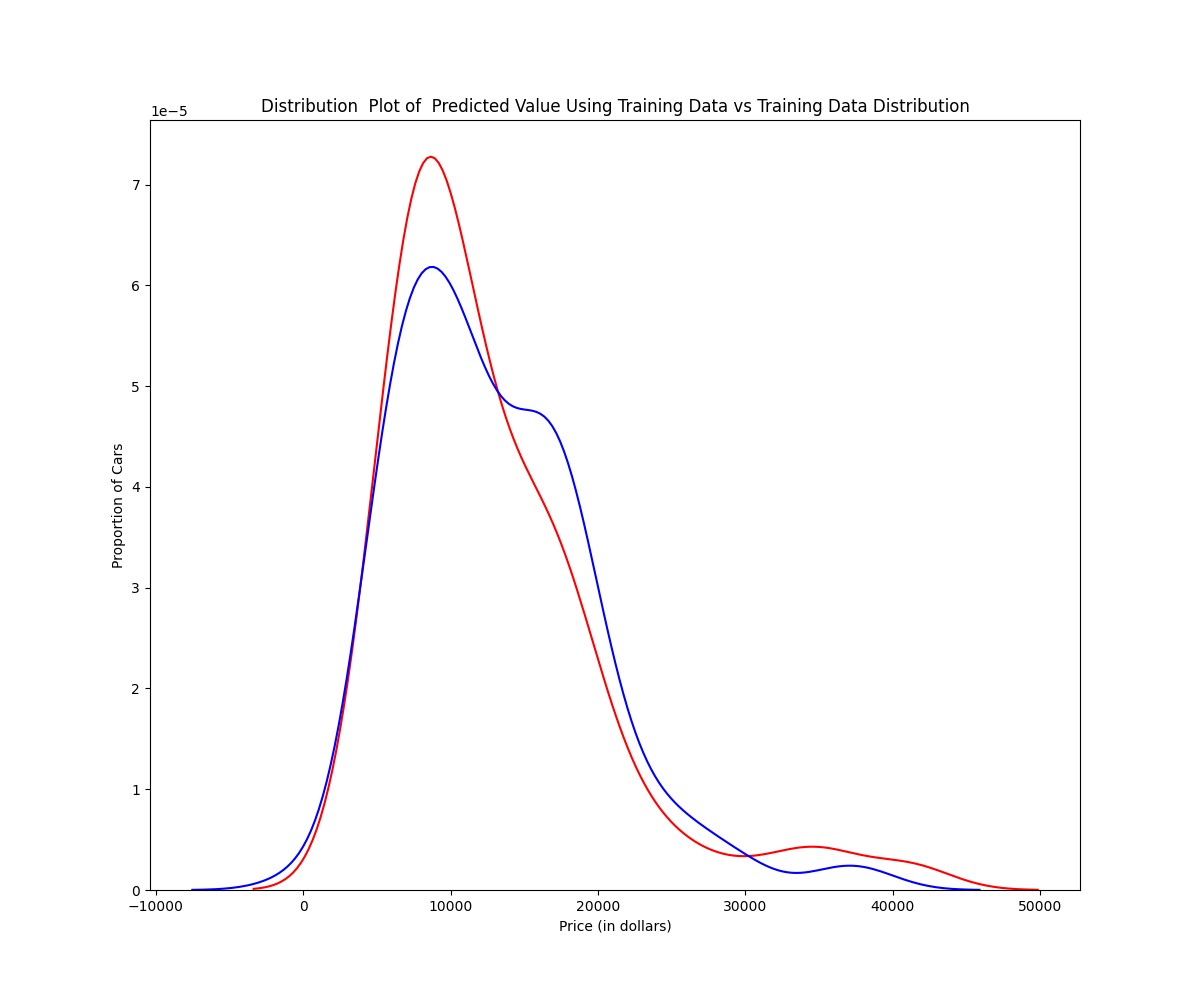

In [50]:
Title ='Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.


So far, the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values.


<ipython-input-49-122ce36d6117>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
<ipython-input-49-122ce36d6117>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, 

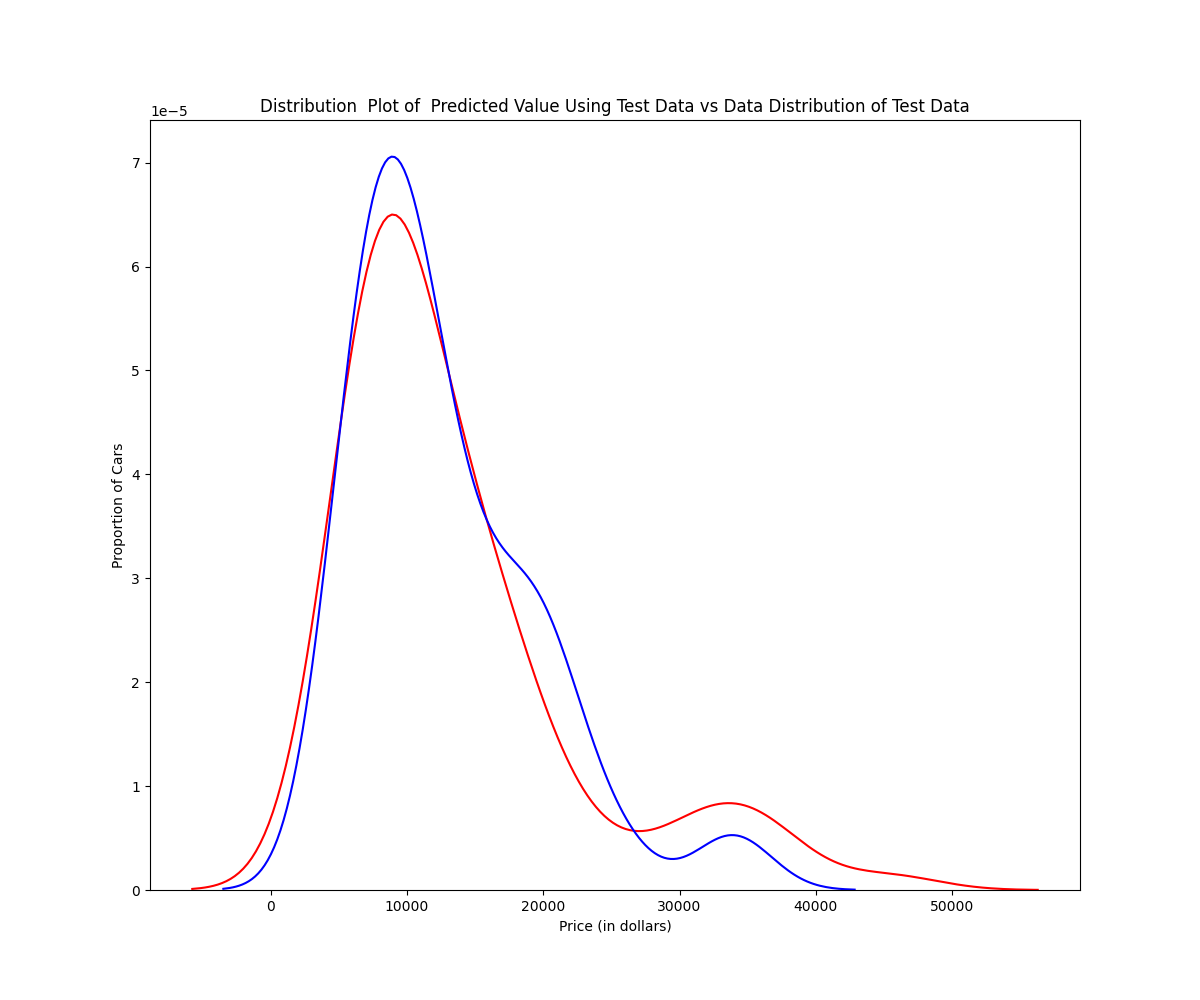

In [51]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Figure 2: Plot of predicted value using the test data compared to the actual values of the test data.


<p>Comparing Figure 1 and Figure 2, it is evident that the distribution of the test data in Figure 1 is much better at fitting the data. This difference in Figure 2 is apparent in the range of 5000 to 15,000. This is where the shape of the distribution is extremely different. Let's see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.</p>


In [52]:
from sklearn.preprocessing import PolynomialFeatures

<h4>Overfitting</h4>
<p>Overfitting occurs when the model fits the noise, but not the underlying process. Therefore, when testing your model using the test set, your model does not perform as well since it is modelling noise, not the underlying process that generated the relationship. Let's create a degree 5 polynomial model.</p>


Let's use 55 percent of the data for training and the rest for testing:


In [53]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

We will perform a degree 5 polynomial transformation on the feature <b>'horsepower'</b>.


In [54]:
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5)

Now, let's create a Linear Regression model "poly" and train it.


In [55]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression()

We can see the output of our model using the method "predict." We assign the values to "yhat".


In [56]:
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6728.58641321,  7307.91998787, 12213.73753589, 18893.37919224,
       19996.10612156])

Let's take the first five predicted values and compare it to the actual targets.


In [57]:
print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

Predicted values: [ 6728.58641321  7307.91998787 12213.73753589 18893.37919224]
True values: [ 6295. 10698. 13860. 13499.]


We will use the function "PollyPlot" that we defined at the beginning of the lab to display the training data, testing data, and the predicted function.


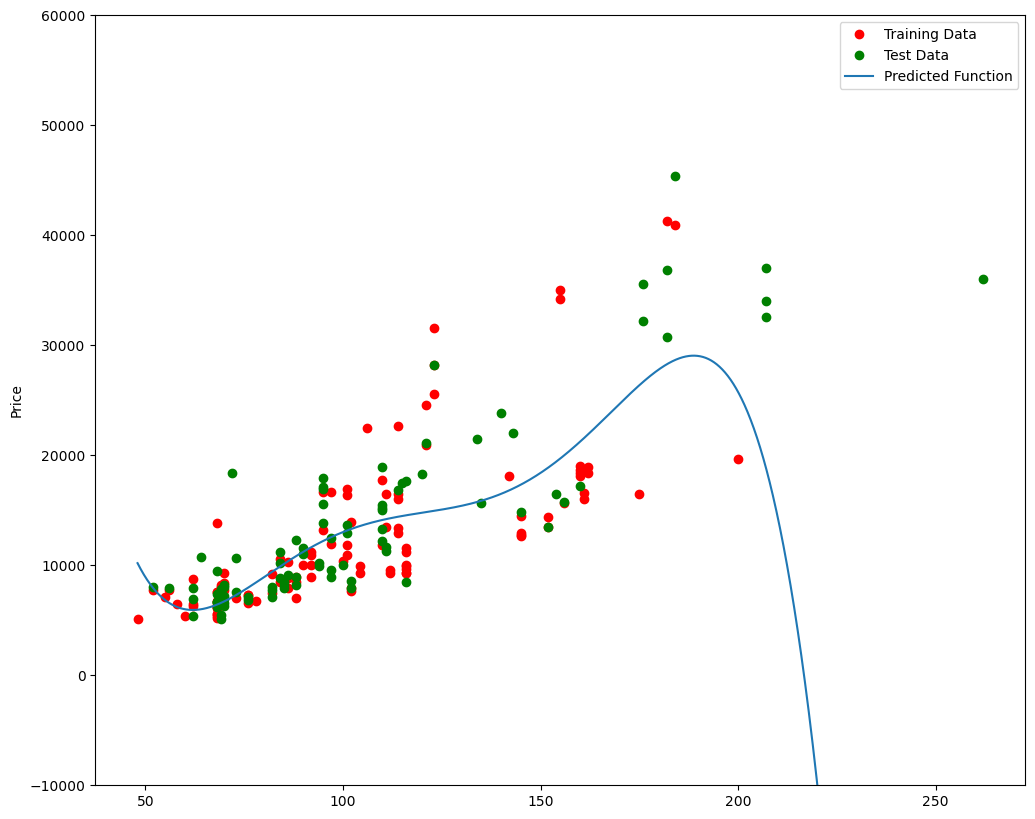

In [58]:
PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly,pr)

Figure 3: A polynomial regression model where red dots represent training data, green dots represent test data, and the blue line represents the model prediction.


We see that the estimated function appears to track the data but around 200 horsepower, the function begins to diverge from the data points.


R^2 of the training data:


In [59]:
poly.score(x_train_pr, y_train)

0.5567716897754004

R^2 of the test data:


In [60]:
poly.score(x_test_pr, y_test)

-29.87099623387278

We see the R^2 for the training data is 0.5567 while the R^2 on the test data was -29.87.  The lower the R^2, the worse the model. A negative R^2 is a sign of overfitting.


Let's see how the R^2 changes on the test data for different order polynomials and then plot the results:


Text(3, 0.75, 'Maximum R^2 ')

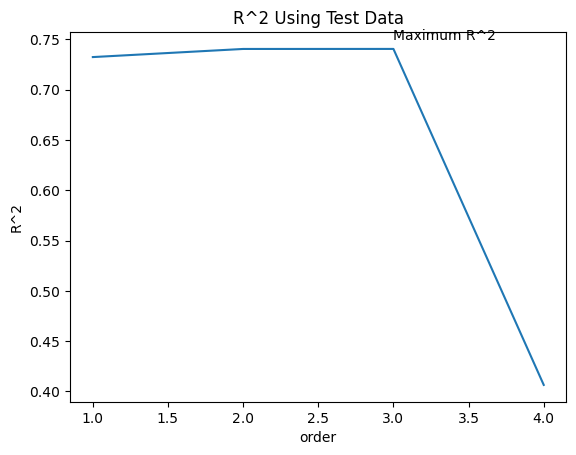

In [61]:
Rsqu_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    
    x_test_pr = pr.fit_transform(x_test[['horsepower']])    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')    

We see the R^2 gradually increases until an order three polynomial is used. Then, the R^2 dramatically decreases at an order four polynomial.


The following function will be used in the next section. Please run the cell below.


In [62]:
def f(order, test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr = PolynomialFeatures(degree=order)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    poly = LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train,y_test, poly, pr)

The following interface allows you to experiment with different polynomial orders and different amounts of data.


interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

<function __main__.f(order, test_data)>

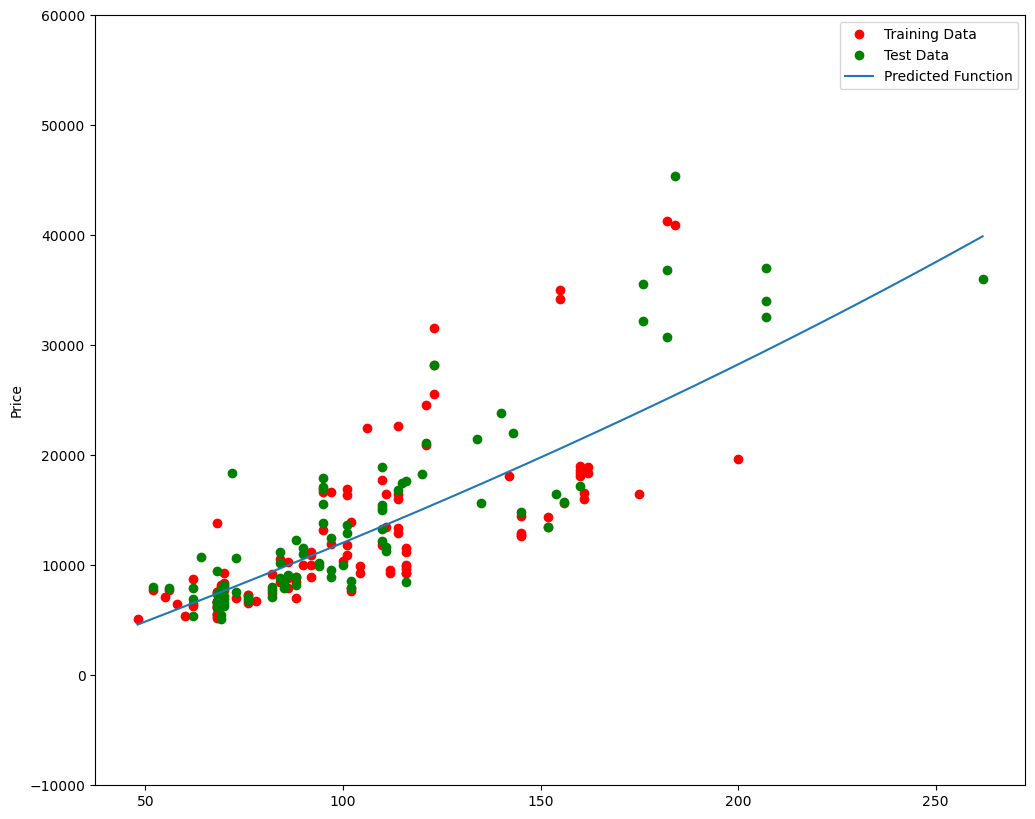

In [63]:
interact(f, order=(0, 6, 1), test_data=(0.05, 0.95, 0.05))

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4a):</h1>

<b>We can perform polynomial transformations with more than one feature. Create a "PolynomialFeatures" object "pr1" of degree two.</b>

</div>


In [64]:
# Write your code below and press Shift+Enter to execute 
pr1=PolynomialFeatures(degree=2)

<details><summary>Click here for the solution</summary>

```python
pr1=PolynomialFeatures(degree=2)

```

</details>


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4b): </h1>

<b> 
 Transform the training and testing samples for the features 'horsepower', 'curb-weight', 'engine-size' and 'highway-mpg'. Hint: use the method "fit_transform".</b>
</div>


In [65]:
# Write your code below and press Shift+Enter to execute 
x_train_pr1=pr1.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

x_test_pr1=pr1.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])


<details><summary>Click here for the solution</summary>

```python
x_train_pr1=pr1.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

x_test_pr1=pr1.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])


```

</details>


<!-- The answer is below:

x_train_pr1=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
x_test_pr1=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

-->


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4c): </h1>
<b> 
How many dimensions does the new feature have? Hint: use the attribute "shape".
</b>
</div>


In [66]:
# Write your code below and press Shift+Enter to execute 
x_train_pr1.shape #there are now 15 features

(110, 15)

<details><summary>Click here for the solution</summary>

```python
x_train_pr1.shape #there are now 15 features


```

</details>


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4d): </h1>

<b> 
Create a linear regression model "poly1". Train the object using the method "fit" using the polynomial features.</b>
</div>


In [67]:
# Write your code below and press Shift+Enter to execute 
poly1=LinearRegression().fit(x_train_pr1,y_train)

<details><summary>Click here for the solution</summary>

```python
poly1=LinearRegression().fit(x_train_pr1,y_train)


```

</details>


 <div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4e): </h1>
<b>Use the method  "predict" to predict an output on the polynomial features, then use the function "DistributionPlot" to display the distribution of the predicted test output vs. the actual test data.</b>
</div>


<ipython-input-49-122ce36d6117>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
<ipython-input-49-122ce36d6117>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, 

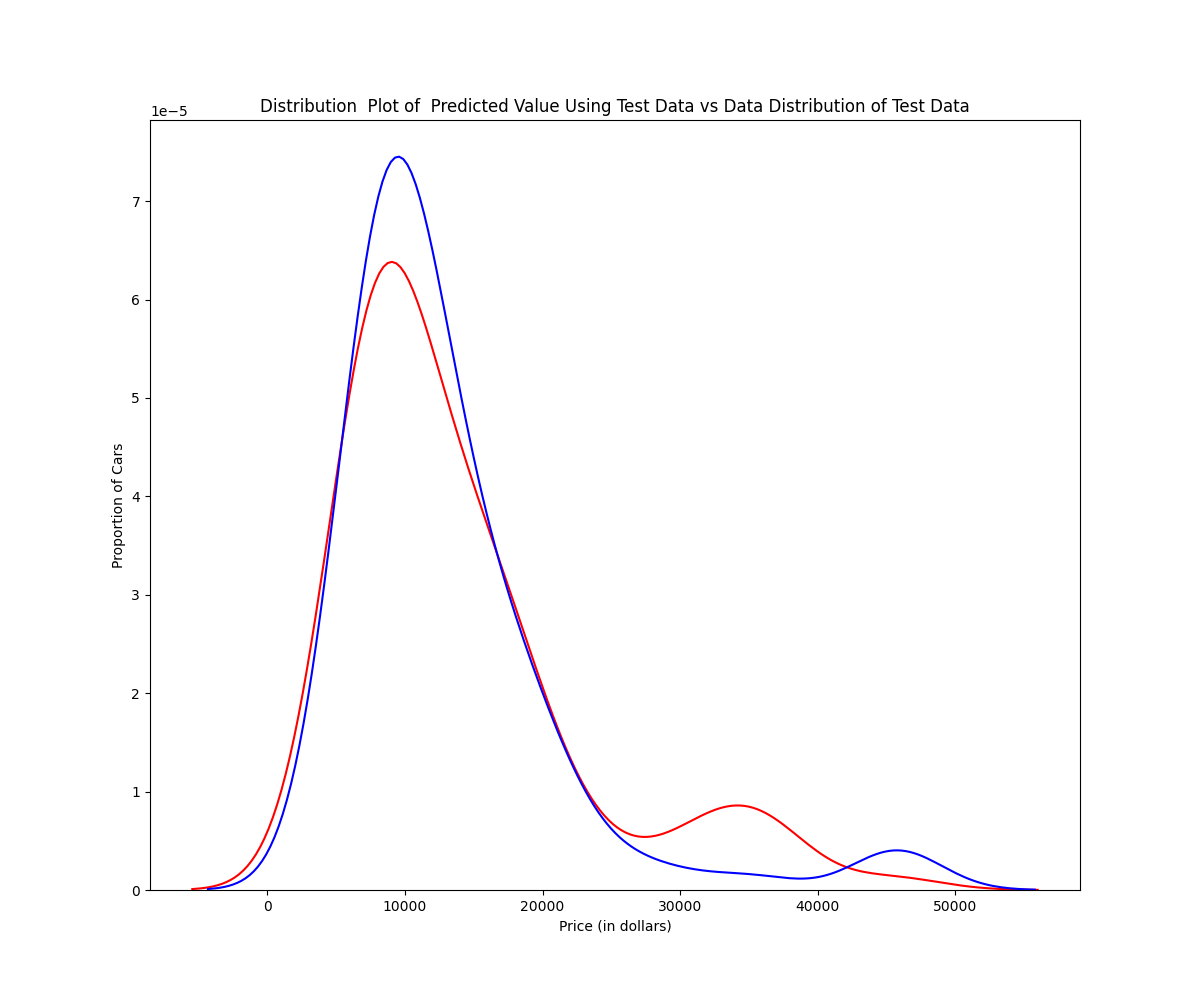

In [68]:
# Write your code below and press Shift+Enter to execute 
yhat_test1=poly1.predict(x_test_pr1)

Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'

DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)


<details><summary>Click here for the solution</summary>

```python
yhat_test1=poly1.predict(x_test_pr1)

Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'

DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)

```

</details>


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4f): </h1>

<b>Using the distribution plot above, describe (in words) the two regions where the predicted prices are less accurate than the actual prices.</b>

</div>


In [69]:
# Write your code below and press Shift+Enter to execute 
#The predicted value is higher than actual value for cars where the price $10,000 range, conversely the predicted price is lower than the price cost in the $30,000 to $40,000 range. As such the model is not as accurate in these ranges.


<details><summary>Click here for the solution</summary>

```python
#The predicted value is higher than actual value for cars where the price $10,000 range, conversely the predicted price is lower than the price cost in the $30,000 to $40,000 range. As such the model is not as accurate in these ranges.

```

</details>


<h2 id="ref3">Part 3: Ridge Regression</h2> 


In this section, we will review Ridge Regression and see how the parameter alpha changes the model. Just a note, here our test data will be used as validation data.


Let's perform a degree two polynomial transformation on our data.


In [70]:
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])

Let's import  <b>Ridge</b>  from the module <b>linear models</b>.


In [71]:
from sklearn.linear_model import Ridge

Let's create a Ridge regression object, setting the regularization parameter (alpha) to 0.1


In [72]:
RigeModel=Ridge(alpha=1)

Like regular regression, you can fit the model using the method <b>fit</b>.


In [73]:
RigeModel.fit(x_train_pr, y_train)

Ridge(alpha=1)

Similarly, you can obtain a prediction:


In [74]:
yhat = RigeModel.predict(x_test_pr)

Let's compare the first five predicted samples to our test set:


In [75]:
print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 6570.82441941  9636.24891471 20949.92322738 19403.60313255]
test set : [ 6295. 10698. 13860. 13499.]


We select the value of alpha that minimizes the test error. To do so, we can use a for loop. We have also created a progress bar to see how many iterations we have completed so far.


In [76]:
from tqdm import tqdm

Rsqu_test = []
Rsqu_train = []
dummy1 = []
Alpha = 10 * np.array(range(0,1000))
pbar = tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha) 
    RigeModel.fit(x_train_pr, y_train)
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)
    
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

<ipython-input-76-e0c60797668d>:7: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  pbar = tqdm(Alpha)
100%|##########| 1000/1000 [00:11<00:00, 85.91it/s, Test Score=0.564, Train Score=0.859]


We can plot out the value of R^2 for different alphas:


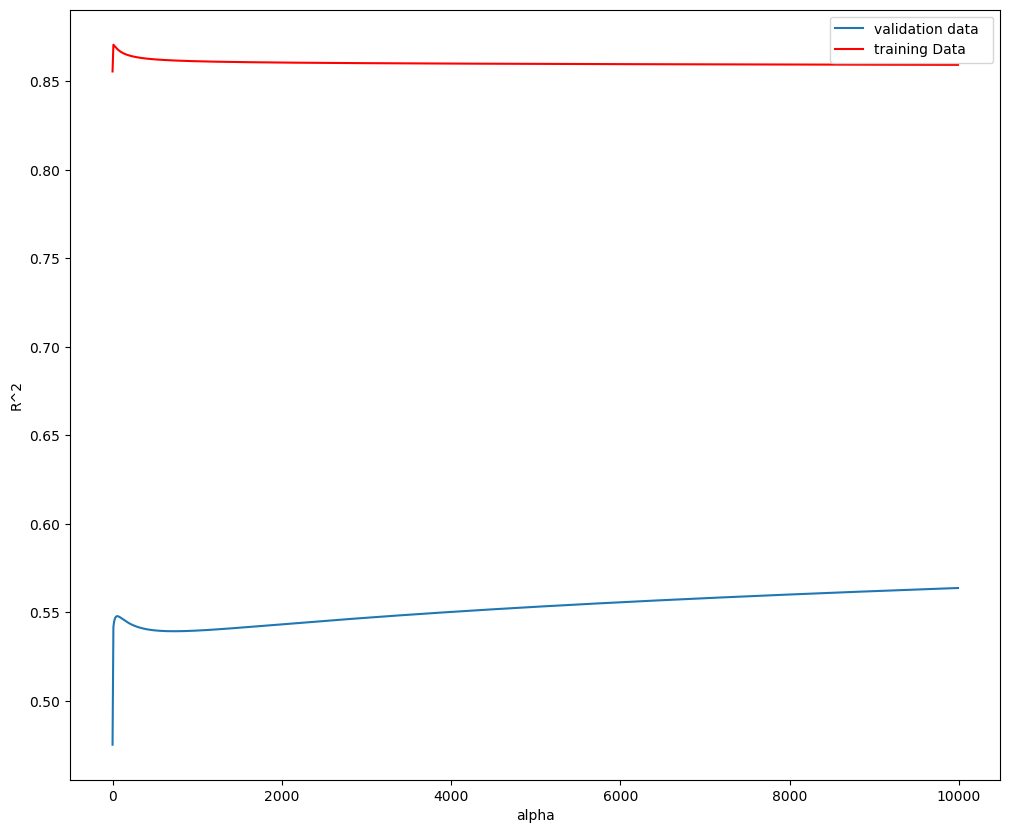

In [77]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

**Figure 4**: The blue line represents the R^2 of the validation data, and the red line represents the R^2 of the training data. The x-axis represents the different values of Alpha.


Here the model is built and tested on the same data, so the training and test data are the same.

The red line in Figure 4 represents the R^2 of the training data. As alpha increases the R^2 decreases. Therefore, as alpha increases, the model performs worse on the training data

The blue line represents the R^2 on the validation data. As the value for alpha increases, the R^2 increases and converges at a point.


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #5): </h1>

Perform Ridge regression. Calculate the R^2 using the polynomial features, use the training data to train the model and use the test data to test the model. The parameter alpha should be set to 10.

</div>


In [78]:
# Write your code below and press Shift+Enter to execute 
RigeModel = Ridge(alpha=10) 
RigeModel.fit(x_train_pr, y_train)
RigeModel.score(x_test_pr, y_test)

0.5418576440208844

<details><summary>Click here for the solution</summary>

```python
RigeModel = Ridge(alpha=10) 
RigeModel.fit(x_train_pr, y_train)
RigeModel.score(x_test_pr, y_test)

```

</details>


<h2 id="ref4">Part 4: Grid Search</h2>


The term alpha is a hyperparameter. Sklearn has the class <b>GridSearchCV</b> to make the process of finding the best hyperparameter simpler.


Let's import <b>GridSearchCV</b> from  the module <b>model_selection</b>.


In [ ]:
from sklearn.model_selection import GridSearchCV

We create a dictionary of parameter values:


In [ ]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

Create a Ridge regression object:


In [ ]:
RR=Ridge()
RR

Create a ridge grid search object:


In [ ]:
Grid1 = GridSearchCV(RR, parameters1,cv=4)

Fit the model:


In [ ]:
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable BestRR as follows:


In [ ]:
BestRR=Grid1.best_estimator_
BestRR

We now test our model on the test data:


In [ ]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

### Thank you for completing this lab!

## Author

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDA0101ENSkillsNetwork20235326-2021-01-01" target="_blank">Joseph Santarcangelo</a>

### Other Contributors

<a href="https://www.linkedin.com/in/mahdi-noorian-58219234/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDA0101ENSkillsNetwork20235326-2021-01-01" target="_blank">Mahdi Noorian PhD</a>

Bahare Talayian

Eric Xiao

Steven Dong

Parizad

Hima Vasudevan

<a href="https://www.linkedin.com/in/fiorellawever/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDA0101ENSkillsNetwork20235326-2021-01-01" target="_blank">Fiorella Wenver</a>

<a href="https:// https://www.linkedin.com/in/yi-leng-yao-84451275/ " target="_blank" >Yi Yao</a>.

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                         |
| ----------------- | ------- | ---------- | ------------------------------------------ |
| 2022-08-23        | 2.4     | Malika     | Updated packages by adding keep_going=True |
| 2020-10-30        | 2.3     | Lakshmi    | Changed URL of csv                         |
| 2020-10-05        | 2.2     | Lakshmi    | Removed unused library imports             |
| 2020-09-14        | 2.1     | Lakshmi    | Made changes in OverFitting section        |
| 2020-08-27        | 2.0     | Lavanya    | Moved lab to course repo in GitLab         |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
